# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas', 'pr']
truncations = [18, 18, ]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/PPE/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [6]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [7]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [8]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [9]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [10]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [11]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

# Get data 

In [55]:
path_file = path_files+'npy/'
Mean={}
for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
    Mean_tmp =  pd.read_pickle(path_file+filename).to_xarray().to_array()
    Mean[str(var)] = Mean_tmp[0,:,:].rename({'variable':'mode'})

### BEST observations - tas

In [56]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [57]:
# POUR LES OBSERVATIONS BEST ---- initial cells

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [58]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### GPCP observations - pr

In [59]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename_obs = 'pr_mon_mean_197901-198112_regrid.nc'
var = 'pr'

In [60]:
## --- Initial method
path = path_observation
df_obs = load_monthly_clim(path, filename_obs, var)
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### Weighted anomaly

In [61]:
X_obs = dict()
X_obs_w = dict()
for var in variables :
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
    W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

    ## --Observations
    X_obs[var] = obs[var] - Mean[var]
    X_obs_w[var] = X_obs[var]*W_eof_2D

### PPE simulations 

In [62]:
cpt=0
path_file = path_files+'nc/'
pc_PPE = dict()

for var in variables :
    #trunc = truncations[cpt]
    
    ## --Get the pc_PPE 
    filename = 'CNRMppe_decomposition_EOFpc_'+var+'.nc'
    tmp = xr.open_dataset(path_file+filename)
    pc_PPE[var] = tmp['pcs'][:, :18]
    
    cpt+=1

### Reference simulation p1

In [63]:
variables = ['tas', 'pr']

In [148]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'

p1_amip = dict()
diff_p1 = dict()
X_p1_w = dict()

var = 'tas'
print(var)
p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()
    
## --Full error e(\theta_0)
mod = p1_amip[var]
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var] - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D
    
var = 'pr'
print(var)
p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()
    
## --Full error e(\theta_0)
mod = p1_amip[var]*86400
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var]*86400 - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D
 

tas
pr


# EOF Solver

In [65]:
# PPE amip simulations 
filename='*_amip_*.nc'
N=len(nb_p_list)
amip_tas = {}
amip_pr = {}

i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path = path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip_tas[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    amip_pr[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    i=i+1

In [66]:
n=len(nb_p_list)
amip_tas_list=[0]*(n+1)
amip_tas_list[0] = p1_amip['tas']['tas']
amip_pr_list=[0]*(n+1)
amip_pr_list[0] = p1_amip['pr']['pr']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip_tas[str(nb_p)]
    amip_tas_list[i+1] = tmp
    tmp = amip_pr[str(nb_p)]
    amip_pr_list[i+1] = tmp
    i+=1

In [67]:
matrix = {}
matrix['tas'] = xr.combine_nested(amip_tas_list, concat_dim=['time'])
matrix['pr'] = xr.combine_nested(amip_pr_list, concat_dim=['time'])

In [68]:
## --PPE simulations
mean = {}
anom = {}
anom_w = {}
for var in variables :
    mean[var] = matrix[var].mean(axis=0)
    anom[var] = matrix[var] - mean[var]
    anom_w[var] = (anom[var]*W_eof_3D)

In [69]:
# Create an EOF solver to do the EOF analysis. 
solver = {}
for var in variables :
    solver[var] = Eof(anom_w[var], center=False, weights=None)

In [81]:
eofs = {}
for var in variables :
    eofs[var] = solver[var].eofsAsCovariance(pcscaling=1)

In [82]:
lat = matrix['tas']['lat']
lon = matrix['tas']['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}

for var in variables :
    eofs_xr[var] = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr[var]

In [73]:
var_modes = solver['tas'].varianceFraction()
var_modes

<xarray.DataArray 'variance_fractions' (mode: 103)>
array([5.90293079e-01, 1.43160584e-01, 5.86399346e-02, 3.04170113e-02,
       2.78308094e-02, 2.00188333e-02, 1.52567108e-02, 9.89492521e-03,
       7.96787071e-03, 7.09969062e-03, 6.39898065e-03, 5.59995129e-03,
       4.53449772e-03, 4.23213919e-03, 4.00317490e-03, 3.81854714e-03,
       3.40578282e-03, 2.74169331e-03, 2.61901466e-03, 2.54709194e-03,
       2.36223081e-03, 2.24442203e-03, 2.15818212e-03, 1.97451178e-03,
       1.78778201e-03, 1.72751879e-03, 1.62211836e-03, 1.42821606e-03,
       1.38803816e-03, 1.33157682e-03, 1.24683995e-03, 1.20899273e-03,
       1.07112177e-03, 1.01154736e-03, 9.88032479e-04, 9.71362801e-04,
       9.56457399e-04, 8.63970740e-04, 8.38754997e-04, 8.07111427e-04,
       7.75419917e-04, 7.67657769e-04, 7.45388148e-04, 7.18737813e-04,
       7.10634994e-04, 6.37672281e-04, 6.31413806e-04, 5.93655383e-04,
       5.80578034e-04, 5.60450762e-04, 5.53151241e-04, 5.28599054e-04,
       5.11765213e-04, 4.84937304e-04, 4.78846040e-04, 4.66371542e-04,
       4.52311417e-04, 4.46727255e-04, 4.18031412e-04, 3.97372520e-04,
       3.95876971e-04, 3.84570678e-04, 3.75935702e-04, 3.53836063e-04,
       3.46113828e-04, 3.37205311e-04, 3.20545502e-04, 3.10284156e-04,
       3.05530349e-04, 3.02911000e-04, 2.91747670e-04, 2.88069767e-04,
       2.84380319e-04, 2.76528761e-04, 2.71663432e-04, 2.64566885e-04,
       2.61635203e-04, 2.58077132e-04, 2.46992532e-04, 2.43267871e-04,
       2.39466654e-04, 2.30114342e-04, 2.20565750e-04, 2.17847722e-04,
       2.13451720e-04, 2.04083726e-04, 2.02857779e-04, 1.89606451e-04,
       1.88097080e-04, 1.84579876e-04, 1.81998469e-04, 1.78135817e-04,
       1.71382103e-04, 1.67676301e-04, 1.57839605e-04, 1.55093306e-04,
       1.52560629e-04, 1.48698705e-04, 1.41541694e-04, 1.40478602e-04,
       1.38906047e-04, 1.26445390e-04, 2.84808997e-10])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 94 95 96 97 98 99 100 101 102
Attributes:
    long_name:  variance_fractions

In [ ]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

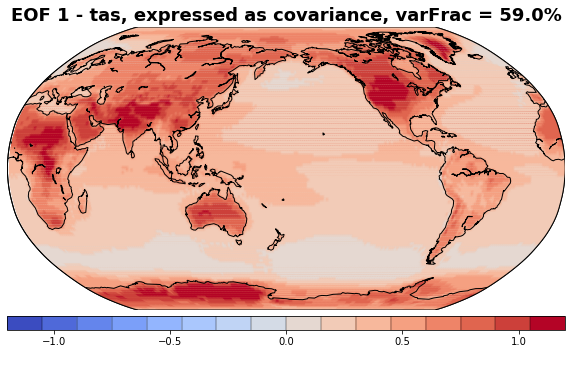

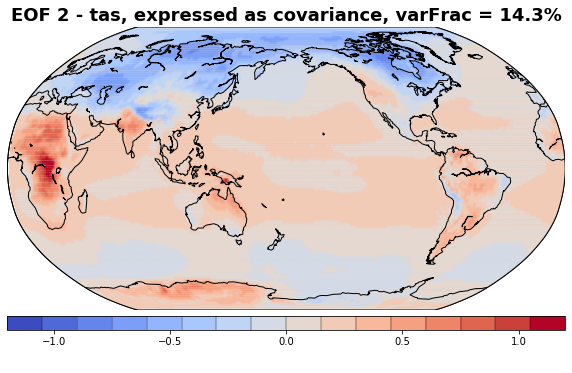

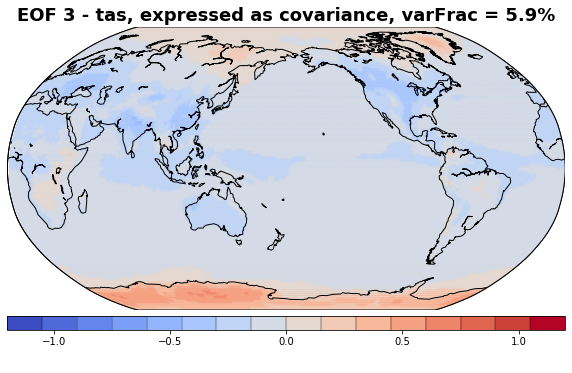

In [72]:
data = -eofs_xr['tas']
label_min = -1.2
label_max = 1.2

for eof_nb in [1,2,3] :

    title = "EOF "+str(eof_nb)+" - tas, expressed as covariance, varFrac = "+str(float((var_modes[eof_nb-1]*100).round(1)))+"%"
    name_figure = "MEOF_EOFmap"+str(eof_nb)+"_tas.png"
    eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

# Emulations 100 000

In [27]:
path = "/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param_standard.npy")
X = np.load(file=path+"/X_EmulateurFeedbacksN.npy")
param_names = np.load(file=path+"/LHS_paramNames.npy")

pc_pred = {}
for var in variables :
    pc_pred[var] = []
    for i in range(0,18,1) :
        #print(i)
        y = pc_PPE[var][:, i]
        tmp = MultiLinReg_pred(LHS, X ,y, param_names)
        pc_pred[var].append(tmp)


In [28]:
df_pc_pred = {}
for var in variables :
    df_pc_pred[var] = pd.DataFrame(pc_pred[var][0], columns= ['EOF 1'])
    for i in range(1,18,1) :
        ind = 'EOF '+str(i+1)
        df_pc_pred[var][ind] = pc_pred[var][i]
#df_pc_pred

# Calcule RMSE reconstructed (p)

In [79]:
#eofs = {}
#eofs_combined = {}
#for var in variables :
#    eofs[var] = []
#    for j in range(1, 104, 1) :
        ## --Get the eofs
#        eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+var+".npy").to_xarray().to_array()
#        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
#        eofs[var].append(eof_tmp)

    ## --Combine the modes for reconstruction
#    eofs_combined[var] = xr.combine_nested(eofs[var], concat_dim='eofs')

FileNotFoundError: [Errno 2] No such file or directory: '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/npy/CNRMppe_decomposition_EOFmap103_tas.npy'

In [85]:
## --Project and reconstruct the observations
U_obs = {}
X_obs_rec = {}
for var in variables :
    U_obs[var] = solver[var].projectField(X_obs_w[var], neofs=24, weighted=False, eofscaling=1)
    X_obs_rec[var] = reconstruct_X(eofs_combined[var][0:24], pc=U_obs[var], nb_dims=2)

In [31]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

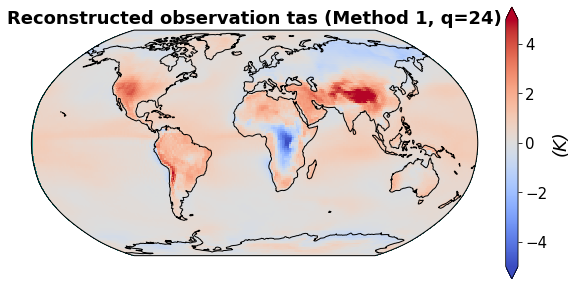

In [77]:
dataset = X_obs_rec['tas']
var = dataset[:]
palette = "coolwarm"
xmin = -5
xmax = 5
label = '(K)'
title = 'Reconstructed observation tas (Method 1, q=24)'
name_fig = 'Rec_obs_tas_meth1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

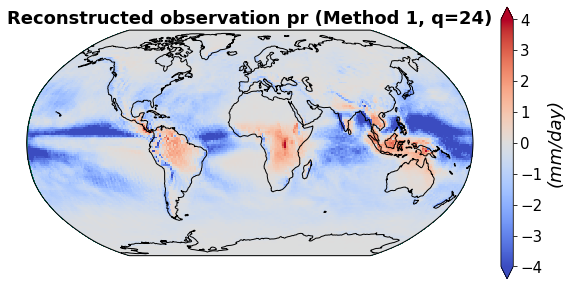

In [78]:
dataset = X_obs_rec['pr']
var = dataset[:]
palette = "coolwarm"
xmin = -4
xmax = 4
label = '(mm/day)'
title = 'Reconstructed observation pr (Method 1, q=24)'
name_fig = 'Rec_obs_pr_meth1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [141]:
variables = ['tas', 'pr']

In [149]:
## --Project and reconstruct p1
U_p1 = {}
X_p1_rec = {}
p_p1 = {}
for var in variables :
    U_p1[var] = solver[var].projectField(X_p1_w[var][var], weighted=False, 
                                         eofscaling=1)
    #X_p1_rec[var] = reconstruct_X(eofs_combined[var], pc=U_p1[var], nb_dims=2)

    ## --Param. error p(\theta_0)
    #p_p1[var] = MSE_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)
#U_p1['tas']

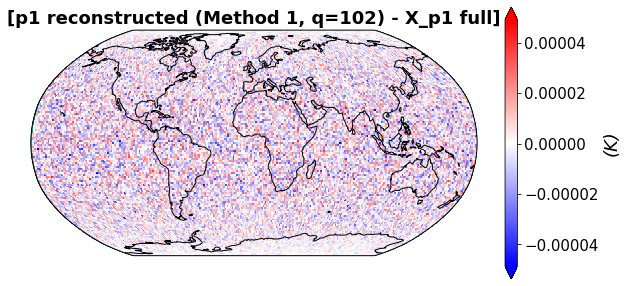

In [55]:
dataset = (X_p1_rec['tas'] - X_p1_w['tas'])['tas']
var = dataset[:]
palette = "bwr"
xmin = var.min()
xmax = var.max()
label = '(K)'
title = '[p1 reconstructed (Method 1, q=102) - X_p1 full]'
name_fig = 'Diff_rec_p1_meth1_full_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

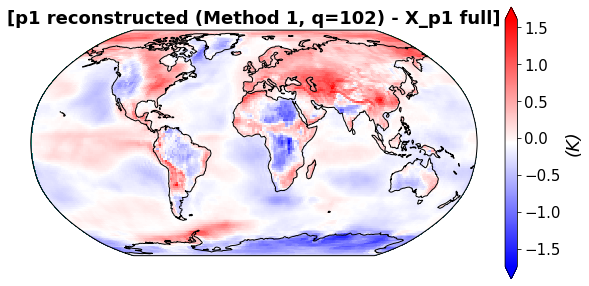

In [38]:
dataset = X_p1_w['tas']['tas']# - X_p1_w['tas'])['tas']
var = dataset[:]
palette = "bwr"
xmin = var.min()
xmax = var.max()
label = '(K)'
title = '[p1 reconstructed (Method 1, q=102) - X_p1 full]'
name_fig = 'Diff_rec_p1_meth1_full_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [57]:
## -- Test 1
U_diff = U_p1['tas'] - U_obs['tas']
X_diff = reconstruct_X(eofs_combined[var], pc=U_diff, nb_dims=2)
tmp = X_diff#/W_eof_2D# + Mean['tas']
diff_tmp = (tmp)**2 * W_rmse_2D
p_T1 = (diff_tmp.sum(['lat', 'lon']))
p_T1

<xarray.DataArray ()>
array(1.52729946)
Coordinates:
    mode     <U4 'eofs'

In [38]:
nb_dims = 2
p_pred = {}
for var in variables :
    print(var)
    p_pred[var] = []
    for i in range(0,100000,1) : 
        pc = df_pc_pred[var].iloc[i]
        X_mod_rec = reconstruct_X(eofs_combined[var], pc[0:18], nb_dims)
        tmp = MSE_rec(X_mod_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_pred[var].append(float(tmp))
    df_pc_pred[var]['p'] = p_pred[var]
    #df_pc_pred

tas
pr


In [39]:
## --Save 
np.save(path_files+'npy/df_pc_pred_tas.npy', df_pc_pred['tas'].values)
np.save(path_files+'npy/df_pc_pred_pr.npy', df_pc_pred['pr'].values)

## Erreure multi-variée 

In [52]:
## -- Create list for column names 
col = []
for i in range(1,19,1) :
    col.append('EOF '+str(i))
col.append('p')
    
## -- load data 
df_pc_pred = {}
for var in variables :
    tmp = np.load(path_files+'npy/df_pc_pred_'+var+'.npy')
    df_pc_pred[var] = pd.DataFrame(tmp, columns=col)


In [87]:
for var in variables :
    df_pc_pred[var]['p_norm'] = df_pc_pred[var]['p']/float(p_p1[var])

df_multi = pd.DataFrame()
df_multi['p_tas_norm'] = df_pc_pred['tas']['p_norm']
df_multi['p_pr_norm'] = df_pc_pred['pr']['p_norm']
df_multi['p_multi'] = (df_multi['p_tas_norm']+df_multi['p_pr_norm'])/2
df_multi

p_tas_norm  p_pr_norm   p_multi
0        1.032369   0.117070  0.574719
1        1.128243   0.128293  0.628268
2        1.216241   0.198015  0.707128
3        2.549504   0.215224  1.382364
4        0.616506   0.170535  0.393520
...           ...        ...       ...
99995    0.681427   0.217181  0.449304
99996    1.684021   0.228029  0.956025
99997    1.206478   0.137340  0.671909
99998    2.407247   0.055540  1.231394
99999    1.163490   0.136926  0.650208

[100000 rows x 3 columns]

In [88]:
## -- Identify best candidate 
best_index = df_multi['p_multi'].idxmin()
best_p_multi = df_multi['p_multi'].iloc[best_index]
best_p_tas_norm = df_multi['p_tas_norm'].iloc[best_index]
best_p_pr_norm = df_multi['p_pr_norm'].iloc[best_index]

In [89]:
best_p_pr_norm

0.22101359030530118

# ---------- Just to select candidates -------------

## Selection lower than ref

In [90]:
cpt_drop=[]
cpt=0
for i in df_multi['p_multi'] : 
    if i>1.0 : 
        cpt_drop.append(cpt)
        cpt+=1
    else :
        cpt+=1

In [91]:
df_pc_best = {}
for var in variables :
    tmp = df_pc_pred[var].copy()
    df_pc_best[var] = tmp.drop(cpt_drop)
    df_pc_best[var] = df_pc_best[var].reset_index()
df_pc_best[var]

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0          0  0.670288 -0.790521  0.029989  0.785455 -0.062077 -0.609458   
1          1  1.095571 -0.999211 -0.020168  0.917900  1.258599  0.056930   
2          2 -0.528764  0.536298  0.526450 -0.336078 -0.467179 -0.248779   
3          4  0.033719 -0.757257 -0.879496 -0.669543 -0.347216  0.714384   
4          5  0.061282 -1.834802 -0.907971 -1.587969 -0.097403  1.194729   
...      ...       ...       ...       ...       ...       ...       ...   
79956  99994 -0.862107  0.145841 -0.228162 -0.548818  0.655254  0.783710   
79957  99995 -0.390304  1.001070 -0.608099  0.483360  1.211396 -0.429256   
79958  99996 -0.569616  0.788116  1.303263  1.504314 -0.452277  0.162624   
79959  99997  0.366495 -0.201414  0.134204  0.175639  0.034514  0.019771   
79960  99999  0.173894 -0.217926  0.112853  0.633414 -0.165441  1.873292   

          EOF 7     EOF 8     EOF 9  ...    EOF 11    EOF 12    EOF 13  \
0      0.876451  0.264218  0.304293  ... -0.441925  0.086703 -0.451636   
1      0.301744  0.382213 -0.473981  ...  0.056880  0.426517  1.160920   
2      0.756709 -0.596996  0.885692  ... -0.150732  0.146812  0.263039   
3     -0.486613  0.006203 -0.952759  ...  0.651977 -0.603233  0.330525   
4     -0.711546 -0.793513 -0.235365  ...  0.024402 -0.971234  0.060953   
...         ...       ...       ...  ...       ...       ...       ...   
79956 -0.539680  0.971426  0.503236  ...  0.458142  0.228707  0.396075   
79957  0.116171  0.477464 -0.038712  ...  0.533115  1.318071 -0.001952   
79958 -0.862755  0.828430 -1.373984  ...  0.543779  1.020082  0.178340   
79959  1.030345 -2.307188 -0.869328  ... -1.312696 -0.685861 -1.054423   
79960 -0.043440 -0.107136  0.207804  ...  0.076502  0.533721 -0.099815   

         EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p    p_norm  
0     -0.143881 -0.444148  0.631852  1.073848  0.874232  1.172499  0.117070  
1     -0.724864  0.372936  1.139522  1.717078  0.408300  1.284901  0.128293  
2     -0.820059  0.395175  1.099081 -0.034834  1.166305  1.983196  0.198015  
3     -1.224742  0.805191  0.000496  1.089089  0.698498  1.707968  0.170535  
4     -0.418991 -0.262695 -0.821049 -0.254316 -0.621489  2.343570  0.233997  
...         ...       ...       ...       ...       ...       ...       ...  
79956  0.178940 -0.091134 -0.963954  0.296419  0.339819  2.616702  0.261268  
79957  1.346793  1.088495  0.407556  0.252647 -0.074069  2.175151  0.217181  
79958 -1.091796 -0.174536 -2.033043  0.699975  1.141386  2.283799  0.228029  
79959  0.609246  0.402423  2.497775 -0.671741  0.110514  1.375516  0.137340  
79960  0.289441 -0.096714 -0.069145 -1.050398 -0.732936  1.371365  0.136926  

[79961 rows x 21 columns]

In [42]:
## -- save
np.save(path_files+'npy/df_pc_low_tas.npy', df_pc_best['tas'].values)
np.save(path_files+'npy/df_pc_low_pr.npy', df_pc_best['pr'].values)

## Compute distances and drop near-neighbors

In [40]:
def Drop_candidates(df_pc_best, nb_drop, d_mean) :
    d_list = {}
    df_pc_best_shuffle = {}
    for var in variables :
        print(var)
        ## -- Shuffle the data :
        #df_pc_best_shuffle[var] = df_pc_best[var].sample(frac=1).reset_index().drop('level_0', axis=1)
    
        ## -- Compute inter-point distances :
        nb_dims = 2
        d_list[var] = []
        ind1_list = []
        ind2_list = []
        for i in range(0,int(len(df_pc_best[var])-1),2) : 
            #print(i)
            pc1 = df_pc_best[var].iloc[i][1:-1]
            pc2 = df_pc_best[var].iloc[i+1][1:-1]
    
            X_pc1 = reconstruct_X(eofs_combined[var], pc1[0:18], nb_dims)
            X_pc2 = reconstruct_X(eofs_combined[var], pc2[0:18], nb_dims)
    
            tmp = MSE_rec(X_pc1, X_pc2, Mean[var], W_rmse_2D)
            d_list[var].append(float(tmp))
            ind1_list.append(i)
            ind2_list.append(i+1)
        
    ## -- Sort distances and select index to drop :
    df_d = pd.DataFrame(d_list['tas'], columns=['d_tas'])
    df_d['d_pr'] = d_list['pr']
    df_d['d_multi'] = df_d['d_tas']/d_mean['tas'] + df_d['d_pr']/d_mean['pr']
    df_d['ind1'] = ind1_list
    df_d['ind2'] = ind2_list
    df_d_sorted = df_d.sort_values(by='d_multi').reset_index()
    print(df_d_sorted)
    ind_drop = []
    for i in range(0, nb_drop, 1) :
        #print(i)
        ind_drop_tmp = random.choice([df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i]])
        #print(df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i])
        #print(ind_drop_tmp)
        ind_drop.append(ind_drop_tmp)
    #print(ind_drop)
    ## -- Drop candidate : 
    df_res = {}
    for var in variables :
        df_res[var] = df_pc_best[var].drop(ind_drop)
    
    ## -- Return DataFrame - 1 candidates : 
    return df_res

In [44]:
d_list = {}
d_mean = {}
for var in variables :
        print(var)
        
        ## -- Compute inter-point distances :
        nb_dims = 2
        d_list[var] = []
        for i in range(0,int(len(df_pc_best[var])-1),2) : 
            #print(i)
            pc1 = df_pc_best[var].iloc[i][1:-1]
            pc2 = df_pc_best[var].iloc[i+1][1:-1]
    
            X_pc1 = reconstruct_X(eofs_combined[var], pc1[0:18], nb_dims)
            X_pc2 = reconstruct_X(eofs_combined[var], pc2[0:18], nb_dims)
    
            tmp = MSE_rec(X_pc1, X_pc2, Mean[var], W_rmse_2D)
            d_list[var].append(float(tmp))
            
        d_mean[var] = float(xr.DataArray(d_list[var]).mean())

tas
pr


In [50]:
## -- Create list for column names 
col = []
for i in range(0,58,1) :
    j = (59-i)
    col.append('index_'+str(j))
col.append('index')

for i in range(1,19,1) :
    col.append('EOF '+str(i))
col.append('p')
col.append('p_norm')

## -- load data
df_pc_best = {}
for var in variables :
    tmp = np.load(path_files+'npy/df_pc_best_'+var+'.npy')
    df_pc_best[var] = pd.DataFrame(tmp, columns=col)

In [56]:
len(df[var])/2

7554.5

In [64]:
nb_drop = 1
#df = df_pc_best.copy()
cpt=0
while len(df['tas']['p']) > 5 :
    print(cpt)
    df = Drop_candidates(df, nb_drop, d_mean)
    df['tas'].rename(columns = {'level_0':'index_'+str(cpt)}, inplace = True)
    df['pr'].rename(columns = {'level_0':'index_'+str(cpt)}, inplace = True)
    df['tas'] = df['tas'].reset_index()
    df['pr'] = df['pr'].reset_index()
    print(df)
    cpt+=1

0
tas
pr
   index       d_tas        d_pr     d_multi  ind1  ind2
0      2   14.494536   32.706475   52.453097     4     5
1      7   36.644572   82.297297  132.194506    14    15
2      1   55.036520  125.224345  200.271053     2     3
3      3   67.343913  154.340168  246.241750     6     7
4      4   67.934398  155.542249  248.239758     8     9
5      8   80.565961  181.811841  291.571955    16    17
6      0   81.422451  182.672999  293.529900     0     1
7      5  106.260738  234.395690  378.808313    10    11
8      6  160.215589  366.024861  584.588885    12    13
{'tas':     level_0  index_0  index_8  index_7  index_6  index_5  index_4  index_3  \
0         0        0        0        0        0        0        0        0   
1         1        2        3        3        3        4        6        7   
2         2        4        5        6        6        7       11       12   
3         3        5        7        9        9       11       16       17   
4         5        8   

{'tas':     level_0  index_1  index_0  index_8  index_7  index_6  index_5  index_4  \
0         0        0        0        0        0        0        0        0   
1         1        1        2        3        3        3        4        6   
2         2        2        4        5        6        6        7       11   
3         3        3        5        7        9        9       11       16   
4         4        5        8       11       15       15       17       24   
5         5        6        9       13       17       19       21       28   
6         6        7       11       15       19       23       25       32   
7         7        8       12       16       20       25       28       35   
8         8        9       13       18       22       27       33       40   
9         9       10       15       21       26       31       37       44   
10       10       11       17       25       30       36       43       51   
11       11       12       18       26       31       37

pr
   index      d_tas        d_pr     d_multi  ind1  ind2
0      3   5.977380   13.217555   21.343168     6     7
1      7  12.845740   29.373612   46.899338    14    15
2      2  13.604798   30.979769   49.532625     4     5
3      6  17.513669   40.473330   64.395454    12    13
4      1  20.760414   47.988116   76.345772     2     3
5      4  30.039487   69.924176  110.988426     8     9
6      0  31.623402   73.760931  117.000202     0     1
7      5  73.508081  169.377594  269.750684    10    11
{'tas':     level_0  index_3  index_2  index_1  index_0  index_8  index_7  index_6  \
0         0        0        0        0        0        0        0        0   
1         1        1        1        1        2        3        3        3   
2         2        2        2        2        4        5        6        6   
3         3        3        3        3        5        7        9        9   
4         4        4        4        5        8       11       15       15   
5         5      

pr
   index      d_tas       d_pr    d_multi  ind1  ind2
0      2   4.425061   9.653649  15.660463     4     5
1      1   6.351467  14.138316  22.778578     2     3
2      3   7.044384  15.971373  25.573249     6     7
3      0   9.425788  21.564820  34.425376     0     1
4      5  16.768094  36.382218  59.131131    10    11
5      4  17.019577  39.623058  62.889357     8     9
{'tas':     level_0  index_6  index_5  index_4  index_3  index_2  index_1  index_0  \
0         0        0        0        0        0        0        0        0   
1         1        1        1        1        1        1        1        2   
2         2        2        2        2        2        2        2        4   
3         3        3        3        3        3        3        3        5   
4         5        5        5        5        5        5        6        9   
5         6        6        6        7        7        7        8       12   
6         7        7        7        8        8        8        9

   index      d_tas       d_pr    d_multi  ind1  ind2
0      2   1.723256   3.153553   5.453183     4     5
1      0   1.961530   3.745405   6.373190     0     1
2      3   3.590575   7.687014  12.551500     6     7
3      4   5.155571  11.181249  18.175379     8     9
4      1  15.275186  31.932378  52.576746     2     3
{'tas':    level_0  index_9  index_8  index_7  index_6  index_5  index_4  index_3  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        1   
2        2        2        2        2        2        2        2        2   
3        3        3        4        5        5        5        5        5   
4        5        6        7        8        8        8        9        9   
5        6        7        8        9        9        9       10       11   
6        7        8        9       10       10       10       11       12   
7        8        9       10       11       11      

   index     d_tas       d_pr    d_multi  ind1  ind2
0      2  1.796361   3.283609   5.680551     4     5
1      3  2.848942   5.699803   9.533414     6     7
2      0  4.245871   6.184937  11.747292     0     1
3      1  8.249745  14.749411  25.735703     2     3
{'tas':    level_0  index_11  index_10  index_9  index_8  index_7  index_6  index_5  \
0        0         0         0        0        0        0        0        0   
1        1         2         2        2        2        2        2        2   
2        2         3         3        3        4        5        5        5   
3        3         4         5        6        7        8        8        8   
4        5         6         7        8        9       10       10       10   
5        6         7         8        9       10       11       11       12   
6        7         8         9       10       11       12       13       14   

   index_4  index_3  ...    EOF 11    EOF 12    EOF 13    EOF 14    EOF 15  \
0        0      

In [67]:
df['pr']

level_0  index_13  index_12  index_11  index_10  index_9  index_8  index_7  \
0        0         0         0         0         0        0        0        0   
1        1         1         1         2         2        2        2        2   
2        2         2         2         3         3        3        4        5   
3        3         3         3         4         5        6        7        8   
4        4         5         6         7         8        9       10       11   

   index_6  index_5  ...    EOF 11    EOF 12    EOF 13    EOF 14    EOF 15  \
0        0        0  ...  0.414431  0.577768 -0.709015  0.930001 -0.726232   
1        2        2  ...  0.307360  0.966768  1.775389  0.926481  0.985074   
2        5        5  ...  0.073431 -1.126255  0.739749 -0.329881 -0.344687   
3        8        8  ...  0.199147  0.986599 -0.088910  0.363315  0.200740   
4       11       12  ...  0.158730 -0.342285  1.405114 -1.332328 -0.535109   

     EOF 16    EOF 17    EOF 18         p    p_norm  
0  1.792210  0.708825 -0.047516  1.363386  0.171719  
1  1.677218 -0.188288 -0.449768  3.157703  0.397714  
2 -0.159927 -1.267141 -0.677843  2.950348  0.371598  
3 -0.035904  0.875884  0.480054  2.761687  0.347836  
4 -1.058764 -0.311233  0.725018  1.094684  0.137876  

[5 rows x 119 columns]

In [77]:
df_multi_candidates = pd.DataFrame()
df_multi_candidates['p_tas_norm'] = df['tas']['p_norm']
df_multi_candidates['p_pr_norm'] = df['pr']['p_norm']
df_multi_candidates['p_multi'] = (df_multi_candidates['p_tas_norm']+df_multi_candidates['p_pr_norm'])/2
df_multi_candidates['p_tas'] = df_multi_candidates['p_tas_norm']*float(p_p1['tas'])
df_multi_candidates['p_pr'] = df_multi_candidates['p_pr_norm']*float(p_p1['pr'])
df_multi_candidates

p_tas_norm  p_pr_norm   p_multi     p_tas      p_pr
0    1.741616   0.171719  0.956667  1.833280  1.363386
1    0.923161   0.397714  0.660437  0.971748  3.157703
2    1.027383   0.371598  0.699490  1.081455  2.950348
3    0.768340   0.347836  0.558088  0.808779  2.761687
4    1.202749   0.137876  0.670312  1.266052  1.094684

In [78]:
## -- save
np.save(path_files+'npy/df_pc_best_tas.npy', df['tas'].values)
np.save(path_files+'npy/df_pc_best_pr.npy', df['pr'].values)
np.save(path_files+'npy/df_multi_candidates.npy', df_multi_candidates.values)

# Figures candidates 

In [14]:
tmp = np.load(path_files+'npy/df_multi_candidates.npy')
df_candidates = pd.DataFrame(tmp, columns = ['p_tas_norm', 'p_pr_norm', 'p_multi', 'p_tas', 'p_pr'])
df_candidates

p_tas_norm  p_pr_norm   p_multi     p_tas      p_pr
0    1.741616   0.171719  0.956667  1.833280  1.363386
1    0.923161   0.397714  0.660437  0.971748  3.157703
2    1.027383   0.371598  0.699490  1.081455  2.950348
3    0.768340   0.347836  0.558088  0.808779  2.761687
4    1.202749   0.137876  0.670312  1.266052  1.094684

In [42]:
## --- name of final columns
col = []
for i in range(1,19,1) :
    tmp = 'EOF '+str(i)
    col.append(tmp)
col.append('p')
col.append('p_norm')
len(col)

## -- name of temporary columns to select

col_sel = []
for i in range(99,119,1):
    col_sel.append((i))
len(col_sel)

## -- to rename the columns 

rename = {}
cpt = 0
for r in col_sel :
    rename[r] = col[cpt]
    cpt+=1

20

In [46]:
tmp = np.load(path_files+'npy/df_pc_best_tas.npy')
df_cand_tas = pd.DataFrame(tmp)
df_short = df_cand_tas[col_sel]
df_tas = df_short.rename(columns = rename)
df_tas

EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  0.713509 -0.743584 -0.023278  0.056729  1.475657 -0.940375  0.324664   
1 -0.345164 -1.205757 -0.314225  0.053263 -0.309785 -1.342005 -0.532734   
2  0.211478 -0.818813 -0.573035  0.022142 -1.343262  0.425483  0.049411   
3 -0.429490 -1.298626  0.996299 -0.347145  0.479571 -0.538850 -1.024892   
4  0.046633  1.325527  0.414319  1.318354 -0.693688  0.576838 -0.710254   

      EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0  1.816206 -0.175087 -0.206129  0.515105  1.368617 -0.178371 -0.566011   
1  0.164462  0.680378  0.174916  0.218911 -0.394492 -0.491198 -1.643942   
2 -1.597450  0.358171 -0.056740 -1.241416 -0.257388 -0.827145 -0.926718   
3  0.510253 -0.900894  0.773591  0.090636  0.732222 -0.074168  1.351431   
4 -1.156239 -0.933490 -0.647502 -0.652712 -0.063024  0.799062  0.053272   

     EOF 15    EOF 16    EOF 17    EOF 18         p    p_norm  
0  0.380190  1.983589  0.070744  0.098732  1.833280  1.741616  
1  0.271035  1.066556  0.221752 -0.714116  0.971748  0.923161  
2  0.442973 -1.384794 -0.724952  0.263017  1.081455  1.027383  
3 -0.624683  0.950136 -0.560874  0.159442  0.808779  0.768340  
4 -0.173913 -1.069470  0.886347  0.025446  1.266052  1.202749

In [47]:
tmp = np.load(path_files+'npy/df_pc_best_pr.npy')
df_cand_pr = pd.DataFrame(tmp)
df_short = df_cand_pr[col_sel]
df_pr = df_short.rename(columns = rename)
df_pr

EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  0.049042 -0.096414  0.128071  0.588414 -1.407553 -0.972359  0.590335   
1 -1.206888 -0.177583 -1.406029 -0.464413 -0.460536 -0.361202  0.422651   
2 -1.210608 -0.031132  0.349181 -0.459508  0.250383  0.308788 -1.280921   
3 -0.915406 -0.115975 -0.422892  0.319769  0.169087  0.819823  0.444355   
4  0.653555 -0.060360  0.324655 -0.007602  0.728515 -0.320989 -0.631485   

      EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0  0.728612 -0.258435  1.386410  0.414431  0.577768 -0.709015  0.930001   
1  0.445717  0.302362  0.444449  0.307360  0.966768  1.775389  0.926481   
2 -1.264150  0.755288 -1.252839  0.073431 -1.126255  0.739749 -0.329881   
3  1.380374 -1.006904  1.023095  0.199147  0.986599 -0.088910  0.363315   
4 -0.258747 -0.661305  0.109453  0.158730 -0.342285  1.405114 -1.332328   

     EOF 15    EOF 16    EOF 17    EOF 18         p    p_norm  
0 -0.726232  1.792210  0.708825 -0.047516  1.363386  0.171719  
1  0.985074  1.677218 -0.188288 -0.449768  3.157703  0.397714  
2 -0.344687 -0.159927 -1.267141 -0.677843  2.950348  0.371598  
3  0.200740 -0.035904  0.875884  0.480054  2.761687  0.347836  
4 -0.535109 -1.058764 -0.311233  0.725018  1.094684  0.137876

In [115]:
df_cand = pd.DataFrame()
for i in [1,2,3] :
    df_cand['EOF'+str(i)+'_tas'] = df_tas['EOF '+str(i)]
    df_cand['EOF'+str(i)+'_pr'] = df_pr['EOF '+str(i)]
df_cand['legend'] = ['candidate 1', 'candidate 2', 'candidate 3', 'candidate 4', 'candidate 5']
df_cand

EOF1_tas   EOF1_pr  EOF2_tas   EOF2_pr  EOF3_tas   EOF3_pr       legend
0  0.713509  0.049042 -0.743584 -0.096414 -0.023278  0.128071  candidate 1
1 -0.345164 -1.206888 -1.205757 -0.177583 -0.314225 -1.406029  candidate 2
2  0.211478 -1.210608 -0.818813 -0.031132 -0.573035  0.349181  candidate 3
3 -0.429490 -0.915406 -1.298626 -0.115975  0.996299 -0.422892  candidate 4
4  0.046633  0.653555  1.325527 -0.060360  0.414319  0.324655  candidate 5

In [116]:
df_emul = pd.DataFrame()
df_emul['EOF1_tas'] = df_pc_pred['tas']['EOF 1']
df_emul['EOF1_pr'] = df_pc_pred['pr']['EOF 1']

df_emul['EOF2_tas'] = df_pc_pred['tas']['EOF 2']
df_emul['EOF2_pr'] = df_pc_pred['pr']['EOF 2']

df_emul['EOF3_tas'] = df_pc_pred['tas']['EOF 3']
df_emul['EOF3_pr'] = df_pc_pred['pr']['EOF 3']

df_emul['legend'] = ['predictions']*100000

df_emul

EOF1_tas   EOF1_pr  EOF2_tas   EOF2_pr  EOF3_tas   EOF3_pr       legend
0      0.053160  0.670288  0.591416 -0.790521  0.177104  0.029989  predictions
1     -0.259237  1.095571  0.647073 -0.999211 -0.452515 -0.020168  predictions
2     -0.050450 -0.528764  0.146491  0.536298 -1.425103  0.526450  predictions
3      1.133615 -0.114458 -1.250214 -1.240433 -1.322137  0.829454  predictions
4     -0.657846  0.033719 -0.100945 -0.757257  2.477285 -0.879496  predictions
...         ...       ...       ...       ...       ...       ...          ...
99995 -0.349083 -0.390304  0.723257  1.001070 -0.359346 -0.608099  predictions
99996  0.925938 -0.569616  0.211934  0.788116 -0.261631  1.303263  predictions
99997 -1.077140  0.366495  0.734859 -0.201414 -1.400953  0.134204  predictions
99998  1.019538  2.176515  1.927900  0.112053 -0.051013  1.480660  predictions
99999  0.215085  0.173894 -0.876168 -0.217926  0.095835  0.112853  predictions

[100000 rows x 7 columns]

In [117]:
df_low = pd.DataFrame()
df_low['EOF1_tas'] = df_pc_best['tas']['EOF 1']
df_low['EOF1_pr'] = df_pc_best['pr']['EOF 1']

df_low['EOF2_tas'] = df_pc_best['tas']['EOF 2']
df_low['EOF2_pr'] = df_pc_best['pr']['EOF 2']

df_low['EOF3_tas'] = df_pc_best['tas']['EOF 3']
df_low['EOF3_pr'] = df_pc_best['pr']['EOF 3']

df_low['legend'] = ['lower than ref']*79961

df_low

EOF1_tas   EOF1_pr  EOF2_tas   EOF2_pr  EOF3_tas   EOF3_pr  \
0      0.053160  0.670288  0.591416 -0.790521  0.177104  0.029989   
1     -0.259237  1.095571  0.647073 -0.999211 -0.452515 -0.020168   
2     -0.050450 -0.528764  0.146491  0.536298 -1.425103  0.526450   
3     -0.657846  0.033719 -0.100945 -0.757257  2.477285 -0.879496   
4     -1.469691  0.061282 -0.875863 -1.834802  1.867064 -0.907971   
...         ...       ...       ...       ...       ...       ...   
79956  0.143116 -0.862107 -0.908388  0.145841  0.486532 -0.228162   
79957 -0.349083 -0.390304  0.723257  1.001070 -0.359346 -0.608099   
79958  0.925938 -0.569616  0.211934  0.788116 -0.261631  1.303263   
79959 -1.077140  0.366495  0.734859 -0.201414 -1.400953  0.134204   
79960  0.215085  0.173894 -0.876168 -0.217926  0.095835  0.112853   

               legend  
0      lower than ref  
1      lower than ref  
2      lower than ref  
3      lower than ref  
4      lower than ref  
...               ...  
79956  lower than ref  
79957  lower than ref  
79958  lower than ref  
79959  lower than ref  
79960  lower than ref  

[79961 rows x 7 columns]

In [131]:
df_obs = pd.DataFrame()
df_obs['EOF1_tas'] = [float(U_obs['tas'][0])]
df_obs['EOF1_pr'] = float(U_obs['pr'][0])

df_obs['EOF2_tas'] = float(U_obs['tas'][1])
df_obs['EOF2_pr'] = float(U_obs['pr'][1])

df_obs['EOF3_tas'] = float(U_obs['tas'][2])
df_obs['EOF3_pr'] = float(U_obs['pr'][2])

df_obs['legend'] = 'obs.'
df_obs

EOF1_tas  EOF1_pr  EOF2_tas   EOF2_pr  EOF3_tas   EOF3_pr legend
0 -0.643135  2.11322 -0.497602  0.420334  1.762247  0.416194   obs.

In [150]:
df_p1 = pd.DataFrame()
df_p1['EOF1_tas'] = [float(U_p1['tas'][0])]
df_p1['EOF1_pr'] = float(U_p1['pr'][0])

df_p1['EOF2_tas'] = float(U_p1['tas'][1])
df_p1['EOF2_pr'] = float(U_p1['pr'][1])

df_p1['EOF3_tas'] = float(U_p1['tas'][2])
df_p1['EOF3_pr'] = float(U_p1['pr'][2])

df_p1['legend'] = 'ref.'
df_p1

EOF1_tas   EOF1_pr  EOF2_tas   EOF2_pr  EOF3_tas   EOF3_pr legend
0  0.040136  0.805869  0.929338  0.413233  0.955584 -0.696692   ref.

In [151]:
df_fig = pd.concat([df_emul, df_low, df_cand, df_obs, df_p1], axis=0)
df_fig

EOF1_tas   EOF1_pr  EOF2_tas   EOF2_pr  EOF3_tas   EOF3_pr       legend
0   0.053160  0.670288  0.591416 -0.790521  0.177104  0.029989  predictions
1  -0.259237  1.095571  0.647073 -0.999211 -0.452515 -0.020168  predictions
2  -0.050450 -0.528764  0.146491  0.536298 -1.425103  0.526450  predictions
3   1.133615 -0.114458 -1.250214 -1.240433 -1.322137  0.829454  predictions
4  -0.657846  0.033719 -0.100945 -0.757257  2.477285 -0.879496  predictions
..       ...       ...       ...       ...       ...       ...          ...
2   0.211478 -1.210608 -0.818813 -0.031132 -0.573035  0.349181  candidate 3
3  -0.429490 -0.915406 -1.298626 -0.115975  0.996299 -0.422892  candidate 4
4   0.046633  0.653555  1.325527 -0.060360  0.414319  0.324655  candidate 5
0  -0.643135  2.113220 -0.497602  0.420334  1.762247  0.416194         obs.
0   0.040136  0.805869  0.929338  0.413233  0.955584 -0.696692         ref.

[179968 rows x 7 columns]

<Figure size 1080x1080 with 0 Axes>

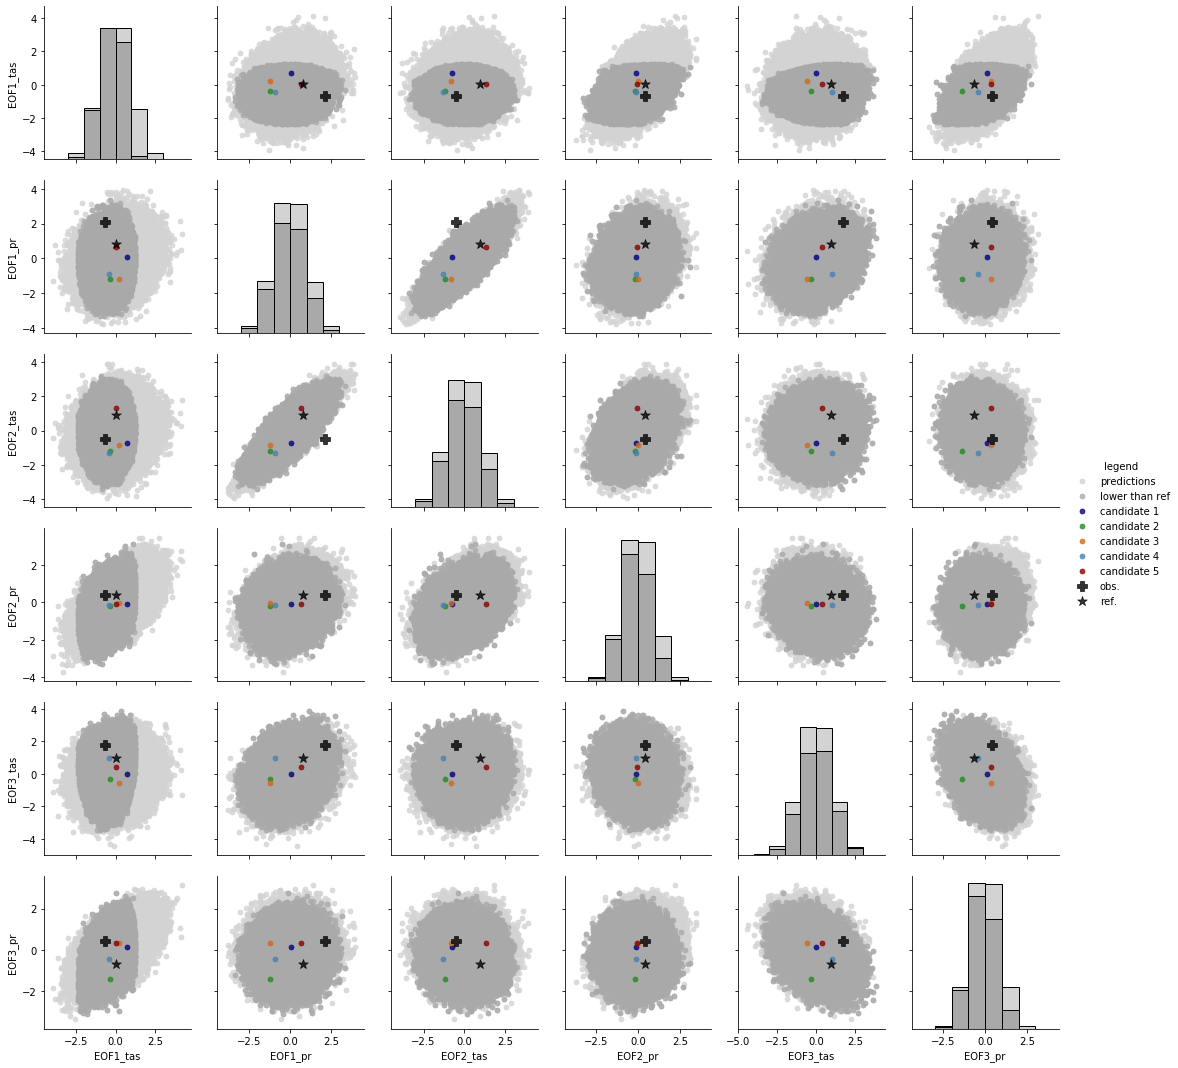

In [152]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF1_tas', 'EOF1_pr', 'EOF2_tas', 'EOF2_pr', 'EOF3_tas', 'EOF3_pr']
p = ['lightgray',  'darkgray','navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred',
     'black', 'black']
m = ['.','.', '.', '.', '.', '.', '.', 'P', '*']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_multi_meth1_EOF.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()

# Identify calibrations for simulations 

In [28]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
df_candidates['index']

1    70483.0
2    27148.0
3    49594.0
4    32895.0
5    44705.0
Name: index, dtype: float64

In [30]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
for i in df_candidates['index']

array([[ 1.06690559, -0.80864907, -1.20495813, ...,  0.35059887,
        -0.69523801, -0.94052341],
       [-0.6868159 , -1.68373542,  0.05488491, ..., -0.26054105,
        -0.84167958,  1.65214998],
       [-0.13255469,  1.41959649, -0.06857148, ...,  1.71118198,
        -0.25010546, -1.66849674],
       ...,
       [ 1.40696829, -0.74360007,  0.05067805, ..., -1.30229692,
        -1.13007354, -1.28834336],
       [-0.52222527, -0.64619873, -1.46604965, ...,  0.73659131,
        -1.47719654, -1.40830002],
       [ 1.62366953, -0.82375762, -0.5057191 , ..., -1.6861202 ,
         0.78220783,  1.44067753]])

In [37]:
path = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param.npy")
df_LHS = pd.DataFrame(LHS)
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
cand_x = []
for i in df_candidates['index'] :
    cand_x_tmp = df_LHS.iloc[int(i)]
    cand_x.append(cand_x_tmp)

In [41]:
xr_cand_x = array(cand_x)

In [42]:
## -- Save in .txt file 
path = '/data/home/globc/peatier/CNRMppe_error_decomposition/files/txt'
np.savetxt(path+'/Candidates_tas_x.txt', xr_cand_x)

# ------------- End of Selection ------------

## Analysis of CNRM-CM candidates runs

In [80]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [81]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [82]:
nb_p_select = ['p901', 'p902', 'p903', 'p904']

In [83]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
amip_select=[]
for p in nb_p_select :
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, variables)
    amip_select.append(amip_tmp)

In [84]:
## --Analysis of the candidates  :
e_sel_list = []
U_sel_list = []
X_sel_rec_list = []
p_sel_list = []
for X_sel in amip_select :
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
          
    ## -- Full error RMSE : 
    e_sel = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel_list.append(e_sel)
    
    ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    U_sel_list.append(U_sel)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined, pc=U_sel, nb_dims=2)
    X_sel_rec_list.append(X_sel_rec)
    
    ## -- Parametric errors RMSE_rec : 
    p_sel = RMSE_rec(X_sel_rec, X_obs_w, Mean, W_rmse_2D)
    p_sel_list.append(float(p_sel))

In [85]:
## -- Faire DataFrame :
df_sel = pd.DataFrame([None]*4, columns= ['index'])

for i in range(0,18,1) :
    U_sel_df = []
    U_sel_df.append(float(U_sel_list[0][i]))
    U_sel_df.append(float(U_sel_list[1][i]))
    U_sel_df.append(float(U_sel_list[2][i]))
    U_sel_df.append(float(U_sel_list[3][i]))
    
    df_sel['EOF '+str(i+1)] = U_sel_df
    
df_sel['p'] = p_sel_list
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404 -0.205207   
1  None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231 -0.194175   
2  None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647 -0.343419   
3  None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069 -1.001579   

      EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0  0.171683  0.009046 -0.749631 -0.865664  0.363790 -0.200908 -1.772613   
1 -0.338823  0.460896  0.086062 -0.978331 -0.165585  1.316583 -0.326901   
2 -0.518185 -0.218918 -0.406787 -1.151575  0.886200 -1.013706 -2.062732   
3 -0.906295 -0.143870  0.156267 -1.231842  0.197991  0.569985 -0.453556   

     EOF 15    EOF 16    EOF 17    EOF 18         p  
0  1.074404 -1.329525 -1.080801  1.869777  1.271452  
1 -0.181695 -0.962893  0.069598 -0.033189  1.333681  
2  0.103687 -0.218105 -1.398216  0.509774  1.248067  
3  0.601147 -0.268341 -1.313195  0.305790  1.432909

## Figure

### Concatenate everything in a big Data Frame 

In [93]:
Names= ['index']
for i in range(1,19,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
Names.append('p')
#Names

In [94]:
## -- Emulated members
df_pc_pred = pd.DataFrame(np.load(path_files+'npy/df_pc_pred.npy'), columns=Names[1:])
df_fig = df_pc_pred.copy().reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

In [95]:
## -- Members with lower error than reference
df_pc_low = pd.DataFrame(np.load(path_files+'npy/df_pc_low.npy'), columns=Names)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

In [96]:
## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = ['index']
for i in U_obs.values :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

In [97]:
## -- Reference CNRM-CM6-1
U_p1_list = []
for i in U_p1.values : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
df_p1['index'] = 0
df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

In [98]:
## -- Emulated candidates
df_pc_best = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)
names = []
for i in range(1, 6, 1) :
    tmp = 'Emulated candidate '+str(i)
    names.append(tmp)
df_pc_best['Legend'] = names 
df_fig = df_fig.append(df_pc_best)
#df_fig

In [99]:
## -- CNRM-CM candidates 
names=[]
for i in range(1,5,1) :
    tmp = 'CNRM-CM candidates '+str(i+1)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)
df_fig

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0       0  0.053160  0.591416  0.177104  0.866376  0.718467  0.659540   
1       1 -0.259237  0.647073 -0.452515  1.409053  0.870643  0.667772   
2       2 -0.050450  0.146491 -1.425103 -0.870566 -0.249998 -0.354165   
3       3  1.133615 -1.250214 -1.322137  1.910634  1.905300  0.142851   
4       4 -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115   
..    ...       ...       ...       ...       ...       ...       ...   
5   44705 -1.622920 -0.500421 -0.435313  0.831580  0.855267 -0.538224   
0    None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404   
1    None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231   
2    None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647   
3    None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069   

       EOF 7     EOF 8     EOF 9  ...    EOF 11    EOF 12    EOF 13    EOF 14  \
0  -0.043037  0.556143  0.368303  ...  0.433413  1.109543  0.321661  1.513375   
1  -1.261793 -0.218841 -0.226251  ... -0.687209 -0.269193  0.721731  1.066529   
2  -0.285270 -1.353141  0.577560  ...  0.106225  1.624095  0.920702  1.138463   
3  -0.127473  0.419342  0.802691  ... -0.373750 -0.253786 -0.894195 -0.389659   
4  -0.430936 -0.878425  0.267369  ...  0.385899  1.002614  0.633993  1.667335   
..       ...       ...       ...  ...       ...       ...       ...       ...   
5  -0.478114  0.727354 -0.755861  ... -0.695699 -0.361838 -0.502221  0.211858   
0  -0.205207  0.171683  0.009046  ... -0.865664  0.363790 -0.200908 -1.772613   
1  -0.194175 -0.338823  0.460896  ... -0.978331 -0.165585  1.316583 -0.326901   
2  -0.343419 -0.518185 -0.218918  ... -1.151575  0.886200 -1.013706 -2.062732   
3  -1.001579 -0.906295 -0.143870  ... -1.231842  0.197991  0.569985 -0.453556   

      EOF 15    EOF 16    EOF 17    EOF 18         p                Legend  
0   0.452024 -0.274895 -0.594091  0.293428   1.03628      Emulated members  
1  -0.923241  1.317171  0.553031 -0.158446   1.10078      Emulated members  
2   1.913375 -1.009275  0.666004 -0.200700   1.38931      Emulated members  
3  -0.691261  0.796069  0.045508  0.170146    2.3142      Emulated members  
4   0.034571 -0.438587 -0.113232 -0.295158  0.807454      Emulated members  
..       ...       ...       ...       ...       ...                   ...  
5   0.861333  0.502769 -0.536147  0.069069   1.02419  Emulated candidate 5  
0   1.074404 -1.329525 -1.080801  1.869777   1.27145  CNRM-CM candidates 2  
1  -0.181695 -0.962893  0.069598 -0.033189   1.33368  CNRM-CM candidates 3  
2   0.103687 -0.218105 -1.398216  0.509774   1.24807  CNRM-CM candidates 4  
3   0.601147 -0.268341 -1.313195  0.305790   1.43291  CNRM-CM candidates 5  

[127055 rows x 21 columns]

<Figure size 1080x1080 with 0 Axes>

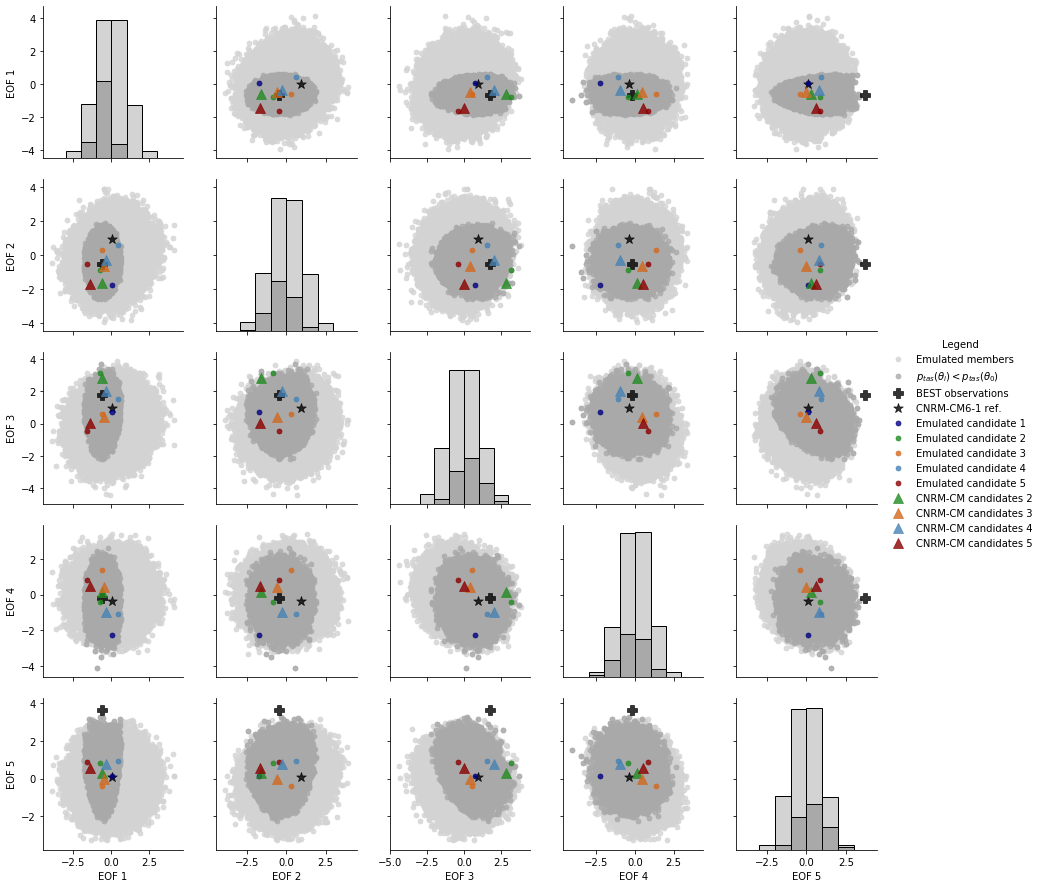

In [101]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray','black', 'black', 
     'navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred', 
     'forestgreen', 'chocolate', 'steelblue', 'darkred' ]
m = ['.','.', 'P','*', 
     '.', '.', '.', '.', '.',
     '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_tas_EOF.png'
plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()

# Spatial maps CNRM-CM candidates

In [44]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff
    

In [45]:
e_diff=[]
p_diff=[]
u_diff=[]
cpt=0
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- 3D full error [obs - mod]
    e_diff_tmp = (obs[variable_obs] - X_sel)
    e_diff.append(e_diff_tmp)
    
     ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_sel[:], nb_dims=2)
    
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff.append(p_diff_tmp)
    
    ## -- 3D u error [e - p]
    u_diff_tmp = (e_diff_tmp - p_diff_tmp)
    u_diff.append(u_diff_tmp)

In [46]:
## -- Compute integrated metrics 
e_sel=[]
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- Compute RMSE 
    e = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel.append(float(e))
df_sel['e'] = e_sel
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404 -0.205207   
1  None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231 -0.194175   
2  None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647 -0.343419   
3  None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069 -1.001579   

      EOF 8     EOF 9  ...    EOF 12    EOF 13    EOF 14    EOF 15    EOF 16  \
0  0.171683  0.009046  ...  0.363790 -0.200908 -1.772613  1.074404 -1.329525   
1 -0.338823  0.460896  ... -0.165585  1.316583 -0.326901 -0.181695 -0.962893   
2 -0.518185 -0.218918  ...  0.886200 -1.013706 -2.062732  0.103687 -0.218105   
3 -0.906295 -0.143870  ...  0.197991  0.569985 -0.453556  0.601147 -0.268341   

     EOF 17    EOF 18         p                Legend         e  
0 -1.080801  1.869777  1.271452  CNRM-CM candidates 1  1.312485  
1  0.069598 -0.033189  1.333681  CNRM-CM candidates 2  1.337315  
2 -1.398216  0.509774  1.248067  CNRM-CM candidates 3  1.269987  
3 -1.313195  0.305790  1.432909  CNRM-CM candidates 4  1.447296  

[4 rows x 22 columns]

In [47]:
## -- p1 reference CNRM-CM6-1

## -- 3D full error [obs - mod]
e_diff_p1 = (obs[variable_obs] - p1_amip)

## -- Project 
X_p1 = p1_amip - Mean
X_p1_w = X_p1*W_eof_2D
U_p1 = solver.projectField(X_p1_w, neofs=18, weighted=False, eofscaling=1)

## --Reconstruct 
X_p1_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_p1[:], nb_dims=2)

## -- 3D p error [X_obs_rec - X_mod_rec]
p_diff_p1 = diff_3D_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)

## -- 3D u error [e - p]
u_diff_p1 = (e_diff_p1 - p_diff_p1)

## Figure

In [48]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

## Reference p1

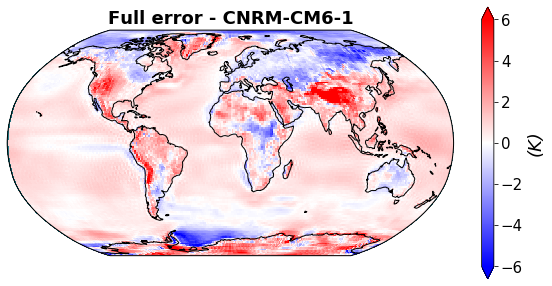

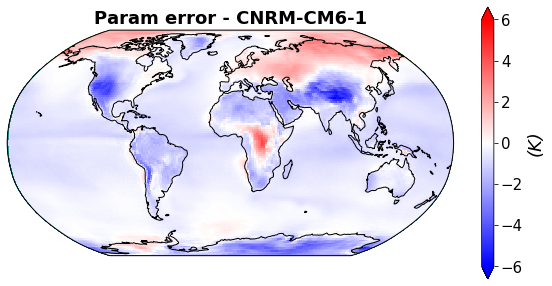

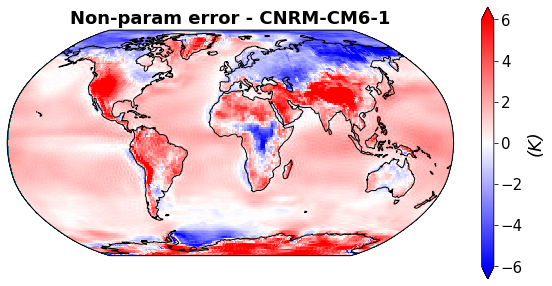

In [49]:
## -- full error e_p1 
dataset = e_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Full error - CNRM-CM6-1'
name_fig = 'Fig4_full_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- param error p_p1 
dataset = p_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Param error - CNRM-CM6-1'
name_fig = 'Fig4_param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- non-param error u_p1 
dataset = u_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Non-param error - CNRM-CM6-1'
name_fig = 'Fig4_non-param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## CNRM-CM candidates 

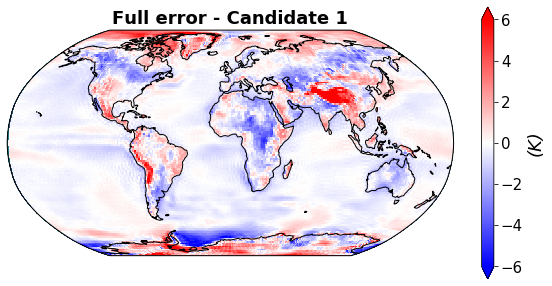

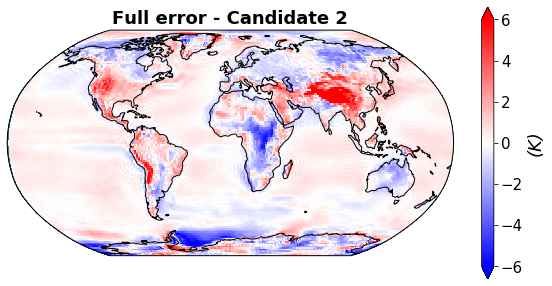

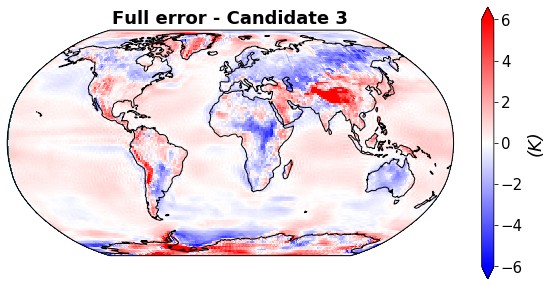

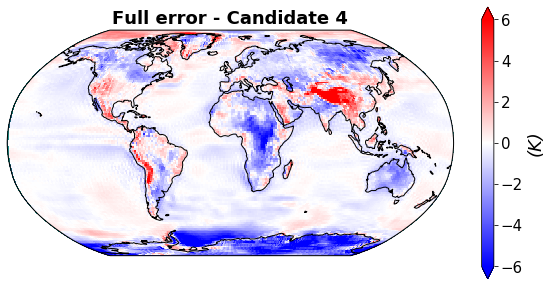

In [50]:
for i in range(0,4,1) :
    dataset = e_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Full error - Candidate '+str(i+1)
    name_fig = 'Fig4_full_error_'+variable+'_candidate'+str(i+1)+'.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

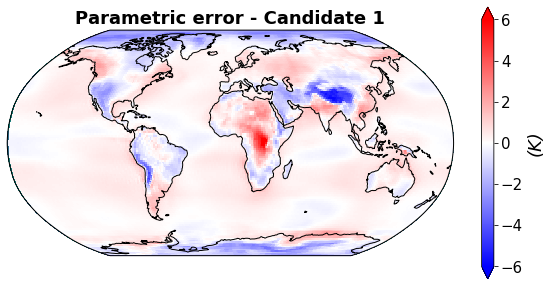

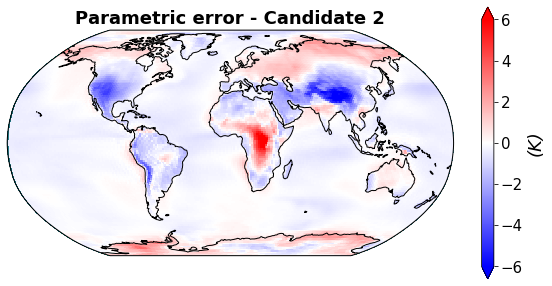

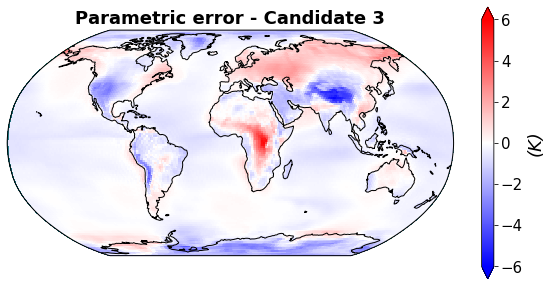

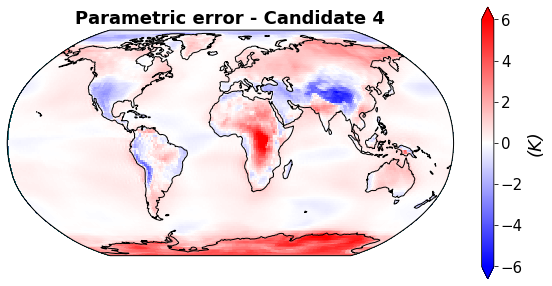

In [51]:
for i in range(0,4,1) :
    dataset = p_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

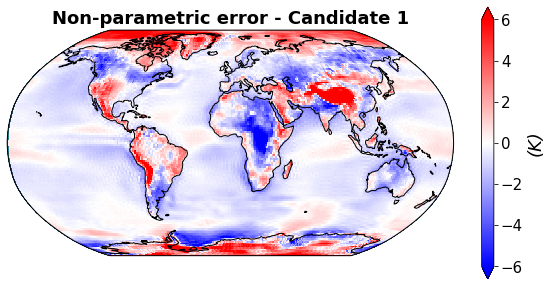

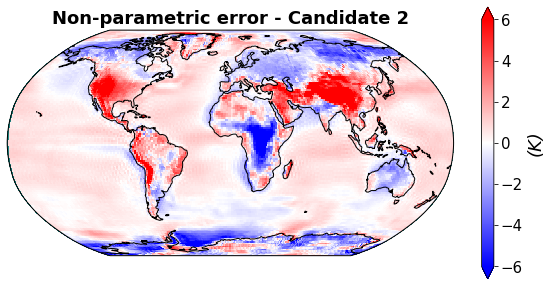

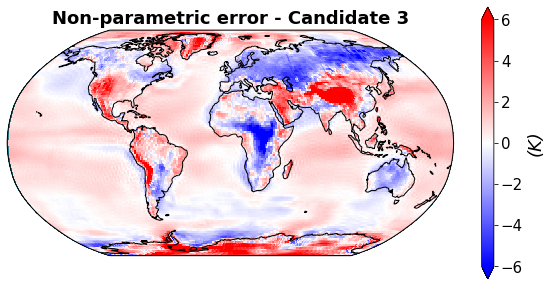

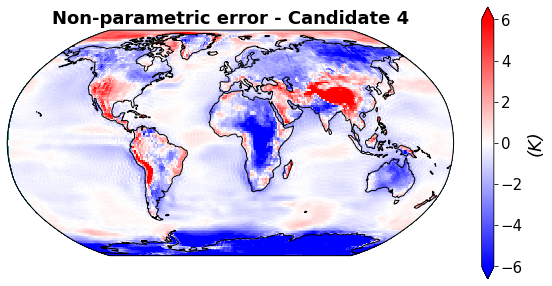

In [52]:
for i in range(0,4,1) :
    dataset = u_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Non-parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_non-param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

# Emulated candidates 

In [53]:
df_cand = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)

## -- Param. error 
p_diff_sel = []
for i in range(1,5,1) :
    U = df_cand.iloc[i][1:19].astype('float')
    
    ## --Reconstruct 
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U, nb_dims=2)
        
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff_sel.append(p_diff)

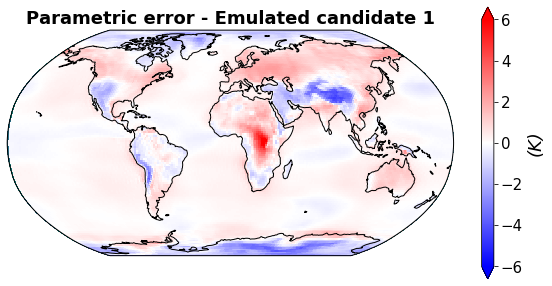

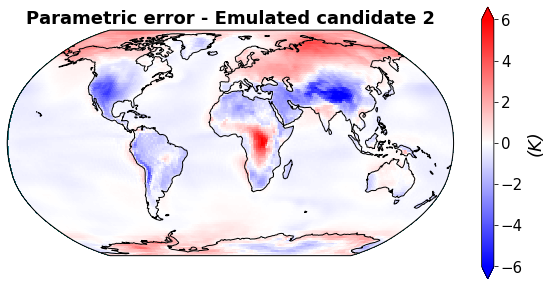

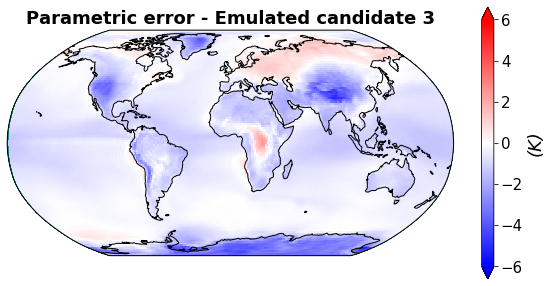

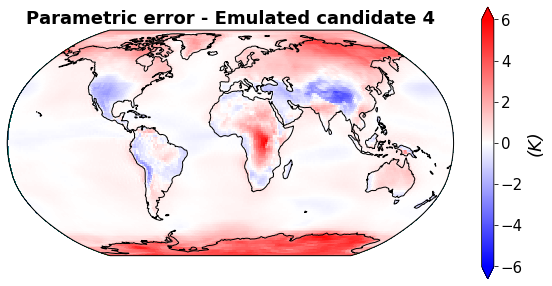

In [54]:
for i in range(0,4,1) :
    dataset = p_diff_sel[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Emulated candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_emul_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [55]:
sqrt(8)

2.8284271247461903

In [56]:
sqrt(4)+sqrt(4)

4.0